In [154]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

In [155]:
import math
import time

import numpy as np
import scipy.sparse as sp
from scipy.linalg import norm, svd, qr
from scipy.stats import ortho_group
import matplotlib.pyplot as plt
from sklearn.decomposition import IncrementalPCA, PCA
from sklearn.preprocessing import StandardScaler

In [156]:
def diffsnorm(data, reconstruct):
    return norm(data-reconstruct)/norm(data+reconstruct)


In [157]:
def eig_error(eig_approx, eig):
    corr = np.linalg.norm(eig_approx-eig)
    corr = np.inner(eig_approx, eig)
    return corr


In [158]:
def subspace_error(U_approx, U):
    n_components = U.shape[1]
    A = U_approx.T.dot(U)
    B = U_approx.dot(U_approx.T)

    err = np.sqrt(n_components+np.trace(B.dot(B)) - 2 * np.trace(A.dot(A.T)))

    frob = np.linalg.norm(U-U_approx, ord='fro')

    return err/np.sqrt(n_components )


In [159]:
def modify_loading(loading, component):
    n_sample, n_component = loading.shape

    minimum = np.amin(loading, axis=0)
    maximum = np.amax(loading, axis=0)

    idx = []

    for i in range(n_sample):
        check = np.where((loading[i, :] == minimum) | (loading[i, :] == maximum), True, False)
        if True in check:
            idx.append(i)

    src_loading = loading[np.array(idx)]
    src_data = src_loading @ component

    return src_data


In [160]:
def process_partition(data, n_components):
    """
    Split data into four partitions and apply PCA on each partition
    """
    partition = []
    
    for i in range(2):
        for j in range(2):
            part = data[i*16:i*16+16, j*16:j*16+16, :, :]
            part_reshape = part.reshape((part.shape[0]*part.shape[1], part.shape[2]*part.shape[3]))
            U, S, V = svd(part_reshape, full_matrices=False)            
            partition.append((U[:, :n_components], S[:n_components], V[:n_components], part_reshape[0]))
    
    return partition


In [161]:
def merge(data, partition, n_components):
    """
    Merge PCA results from partitions
    """
    ipca = IncrementalPCA(n_components=n_components)
    
    for part in partition:
        reconstruct = modify_loading(part[0]*part[1], part[2])
        ipca.partial_fit(reconstruct)
    
    data = data.reshape((1024, 1024))
    data_transformed = ipca.fit_transform(data)
    reconstructed_data = ipca.inverse_transform(data_transformed)
    
    return data_transformed, reconstructed_data
        
        

In [162]:
def run_pca(data, n_components=100, noise_factor=None):
        
    sig_dim = int(math.sqrt(data.shape[0]))
    nav_dim = int(math.sqrt(data.shape[1]))
    
    assert (sig_dim ** 2) == data.shape[0]
    assert (nav_dim ** 2) == data.shape[1]
    
    new_data = data.copy()
    
    if noise_factor:
        noise = np.random.normal(0, 0.1, size=(new_data.shape[0], new_data.shape[1])) * noise_factor
        new_data += noise
    
    # reformat data into sig and nav dimension
    new_data = new_data.reshape((sig_dim, sig_dim, nav_dim, nav_dim))

    partition = process_partition(new_data, n_components)
    data_transformed, reconstructed_data = merge(new_data, partition, n_components)
                    
    return data_transformed, reconstructed_data

In [163]:
from collections import Counter

def max_norm(reconstructed_data, benchmark_data):
    diff = np.abs(reconstructed_data - benchmark_data)
    max_idx = np.argmax(diff, axis=0).tolist()
    count = Counter(max_idx)
    
    return count.most_common(1)

In [164]:
def compare_benchmark(data):
    """
    Compare PCA with standard PCA libraries for benchmarking purpose
    """
    data_transformed, reconstructed_data = run_pca(data, 100)
    norm_diff = diffsnorm(reconstructed_data, data)
    
    assert len(data.shape) == 2
    pca = PCA(n_components=100)
    pca.fit(data)
    
    transformed_data = pca.fit_transform(data)
    benchmark_reconstruct = pca.inverse_transform(transformed_data)
    
    benchmark_diff = diffsnorm(benchmark_reconstruct, data)
    
#     max_diff_frame = max_norm(reconstructed_data, benchmark_reconstruct)
#     print(f"max_diff_frame: {max_diff_frame}")
    
    return norm_diff, benchmark_diff

# data prep

In [165]:
component = ortho_group.rvs(dim=1024)[:100, :]

In [166]:
# standard data generated by 100 components
loading = np.random.rand(1024, 100)
data = loading @ component
np.random.shuffle(data.T)

In [167]:
# random noisy data
noise_data = np.random.rand(1024, 1024)

In [168]:
# A component contained within a single frame
last_component, new_component = component[99], component[:99]
loading = np.random.rand(1024, 99)
single_data = loading @ new_component

In [169]:
# Scale components differently to check if PCA catches them
def scale_data(data, order):
    
    scaler = np.logspace(order, 1, 1024).T
    scaler = scaler.reshape((-1, 1)).T
    np.random.shuffle(scaler.T)
    scaler = np.repeat(scaler, repeats=100, axis=0)
    
    new_component = np.multiply(scaler, component)

    loading = np.random.rand(1024, 100)

    scaled_data = loading @ new_component
    np.random.shuffle(scaled_data.T)
    
    return scaled_data

# Data generated using 100 components vs Noisy data (w/ dimension 1024)

In [170]:
for n_component in range(10, 200, 10):
    U, S, V = svd(data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((data @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.2507812398911834
norm difference wih 20 components using full batch data: 0.22593575338102367
norm difference wih 30 components using full batch data: 0.2023720838150749
norm difference wih 40 components using full batch data: 0.17964363298657712
norm difference wih 50 components using full batch data: 0.15737253552274086
norm difference wih 60 components using full batch data: 0.1349607356148436
norm difference wih 70 components using full batch data: 0.11182816245319482
norm difference wih 80 components using full batch data: 0.0871251250639284
norm difference wih 90 components using full batch data: 0.05838594066468256
norm difference wih 100 components using full batch data: 6.629350872855436e-16
norm difference wih 110 components using full batch data: 6.376807572720492e-16
norm difference wih 120 components using full batch data: 6.393799228376949e-16
norm difference wih 130 components using full batch data: 6.40425092823

In [171]:
for n_component in range(10, 200, 10):
    U, S, V = svd(noise_data, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = (noise_data @ V.T) @ V
    norm_diff = diffsnorm(reconstructed_data, noise_data)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 10 components using full batch data: 0.27128037228062357
norm difference wih 20 components using full batch data: 0.2652271598222611
norm difference wih 30 components using full batch data: 0.25941387734026544
norm difference wih 40 components using full batch data: 0.2538093756768185
norm difference wih 50 components using full batch data: 0.24837156471703345
norm difference wih 60 components using full batch data: 0.24308090717749545
norm difference wih 70 components using full batch data: 0.23794338958291394
norm difference wih 80 components using full batch data: 0.23293824354843093
norm difference wih 90 components using full batch data: 0.22803961350308874
norm difference wih 100 components using full batch data: 0.2232670016419022
norm difference wih 110 components using full batch data: 0.21858889528564024
norm difference wih 120 components using full batch data: 0.21401437368723164
norm difference wih 130 components using full batch data: 0.2095258971393687

In [172]:
data_transformed, reconstructed_data = run_pca(data)
norm_diff = diffsnorm(reconstructed_data, data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 6.119106569243173e-16


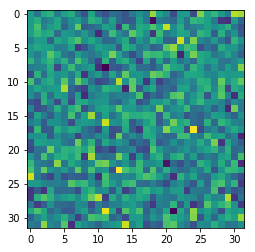

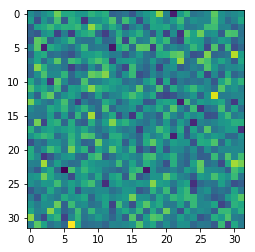

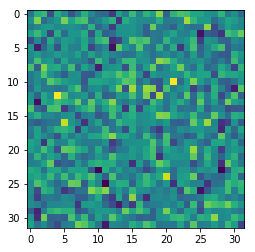

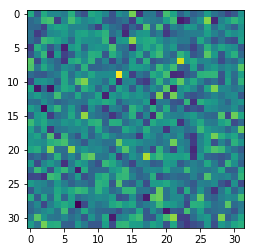

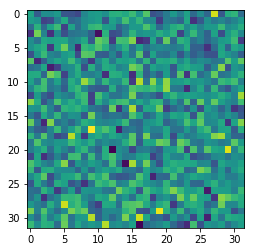

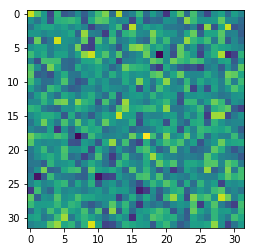

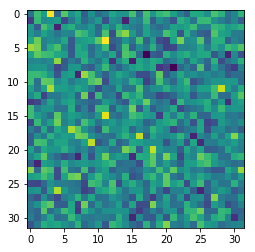

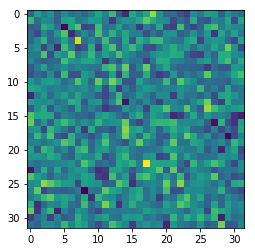

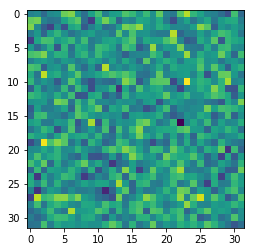

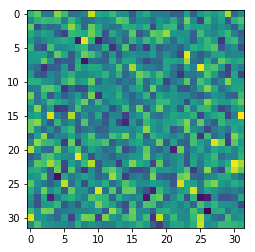

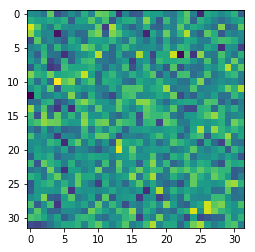

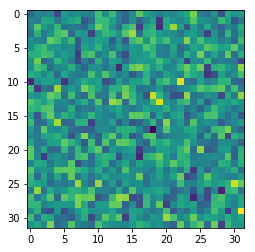

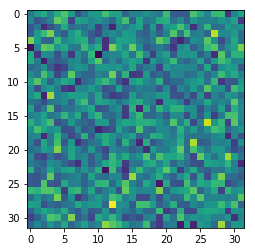

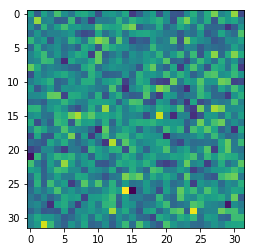

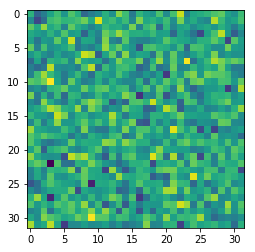

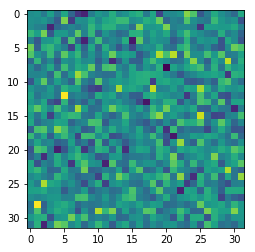

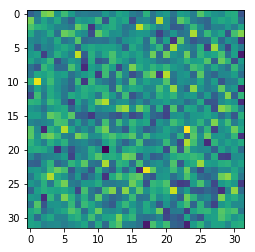

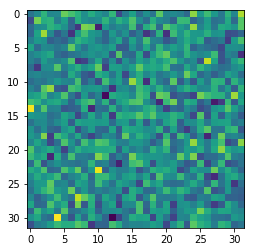

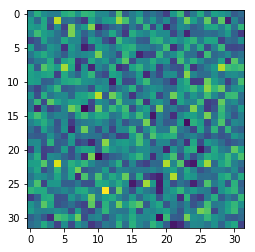

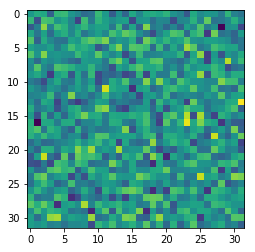

In [173]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)

In [174]:
data_transformed, reconstructed_data = run_pca(data)
norm_diff = diffsnorm(reconstructed_data, data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 6.119106569243173e-16


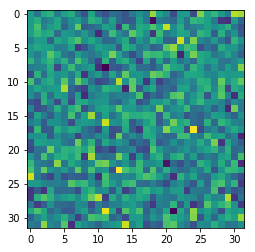

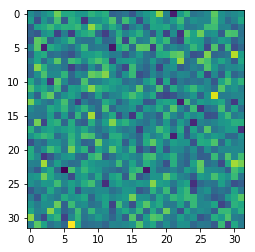

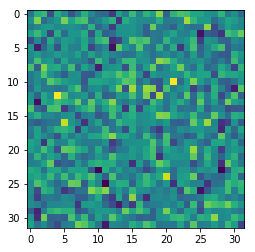

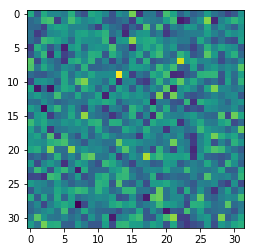

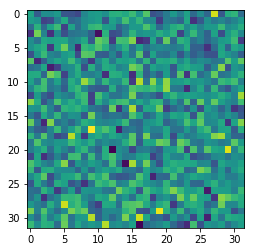

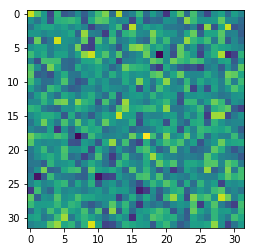

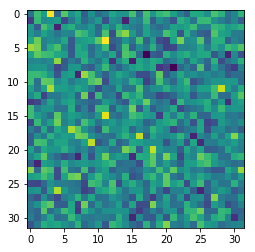

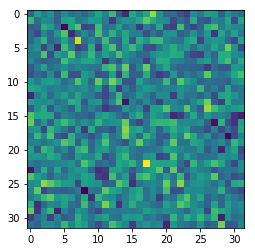

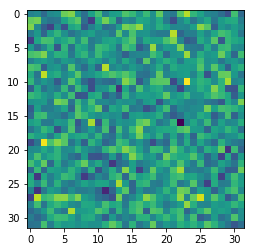

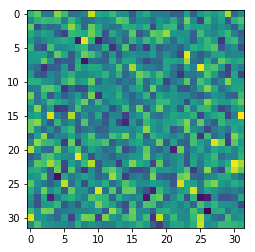

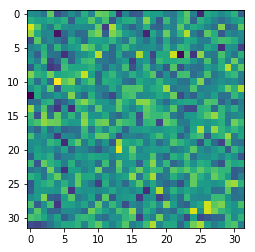

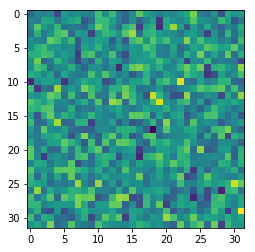

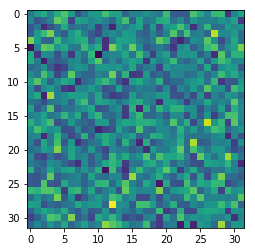

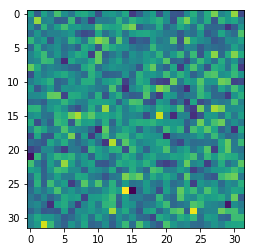

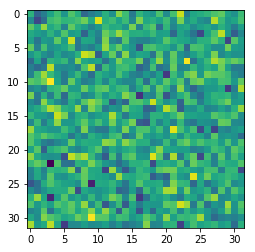

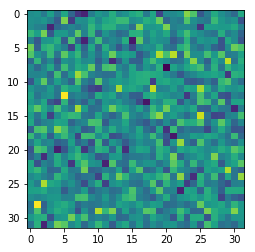

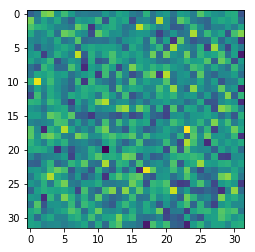

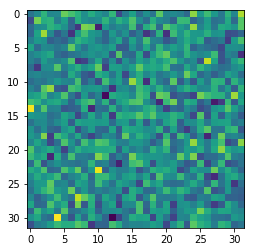

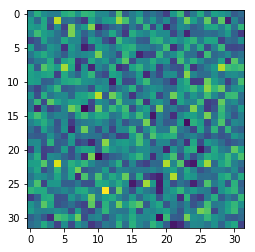

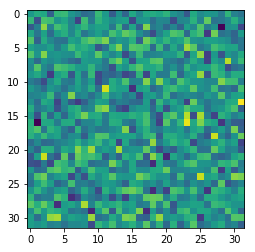

In [175]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


# A component contained only within a single frame

In [176]:
for factor in np.arange(0.05, 1, 0.2):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    print("99 components")
    data_transformed, norm_diff = run_pca(new_single, n_components=99)
    print("100 components")
    data_transformed, norm_diff = run_pca(new_single, n_components=100)

99 components
100 components
99 components
100 components
99 components
100 components
99 components
100 components
99 components
100 components


In [177]:
data_transformed, reconstructed_data = run_pca(single_data)
norm_diff = diffsnorm(reconstructed_data, single_data)
print(f"norm difference between original and reconstructed data: {norm_diff}")

norm difference between original and reconstructed data: 4.904426391987826e-16


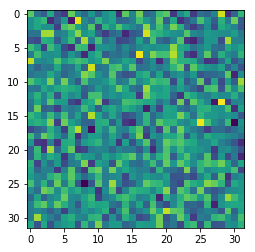

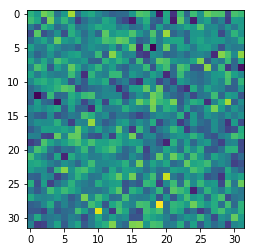

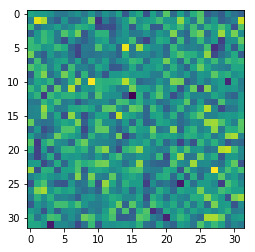

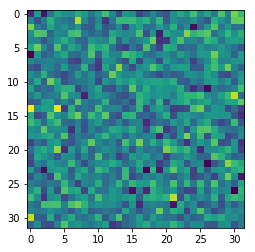

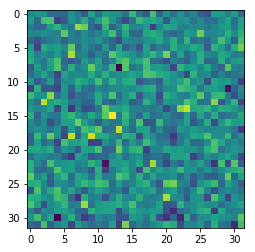

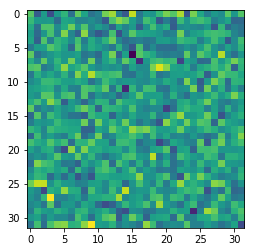

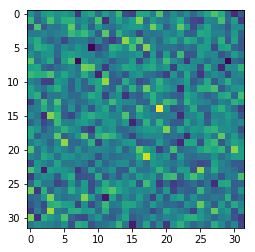

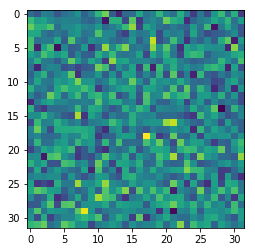

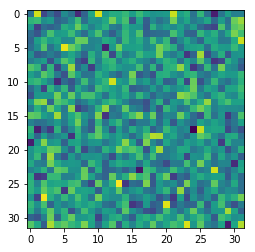

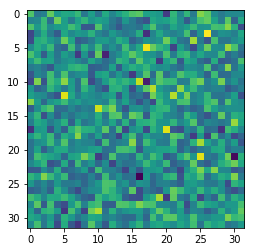

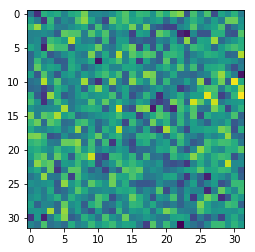

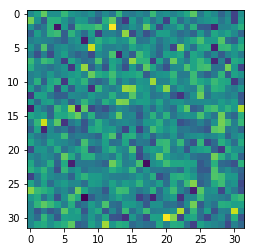

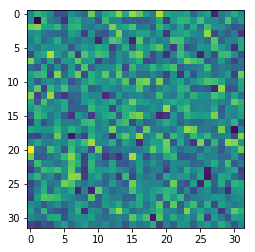

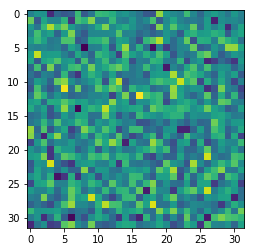

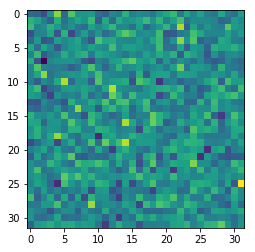

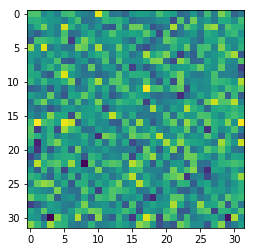

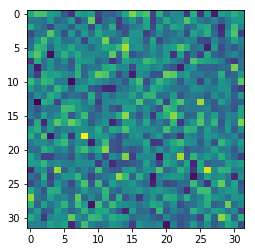

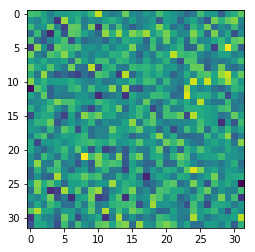

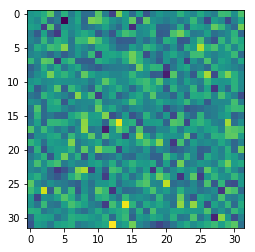

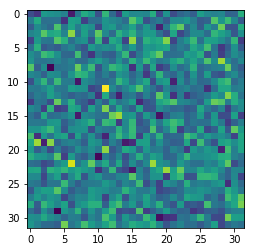

In [178]:
# visualize first 20 components
for i in range(20):
    components = data_transformed[:, i]
    vis = components.reshape((32, 32))

    f, axes = plt.subplots()
    axes.imshow(vis)


In [179]:
for n_component in range(90, 110, 1):
    new_single = single_data.copy()
    new_single[0, :] += last_component * factor
    U, S, V = svd(new_single, full_matrices=False)
    U, S, V = U[:, :n_component], S[:n_component], V[:n_component]
    reconstructed_data = ((new_single @ V.T) @ V)
    norm_diff = diffsnorm(reconstructed_data, new_single)
    print(f"norm difference wih {n_component} components using full batch data: {norm_diff}")

norm difference wih 90 components using full batch data: 0.055795985659839994
norm difference wih 91 components using full batch data: 0.05228738836343658
norm difference wih 92 components using full batch data: 0.04859150645661481
norm difference wih 93 components using full batch data: 0.04474357008141343
norm difference wih 94 components using full batch data: 0.04060030282642359
norm difference wih 95 components using full batch data: 0.03609951249033636
norm difference wih 96 components using full batch data: 0.03106730675606615
norm difference wih 97 components using full batch data: 0.025206948066641695
norm difference wih 98 components using full batch data: 0.017667478916198607
norm difference wih 99 components using full batch data: 0.0022021264568964903
norm difference wih 100 components using full batch data: 5.567003034528436e-16
norm difference wih 101 components using full batch data: 5.576062838899148e-16
norm difference wih 102 components using full batch data: 5.54704

# Differing intensities of component vectors

In [180]:
for j in range(-1, -100, -10):
    for n_components in range(99, 101, 1):
        scaled_data = scale_data(data, order=j)
        data_transformed, reconstructed_data = run_pca(scaled_data, n_components)
        norm_diff = diffsnorm(reconstructed_data, scaled_data)
        print(f"norm difference between original and reconstructed data using {n_components} components: {norm_diff}")
        
        reconstruct_diff, benchmark_diff = compare_benchmark(scaled_data)
        print(f"reconstruct norm difference : {reconstruct_diff}, benchmark norm difference : {benchmark_diff}")

norm difference between original and reconstructed data using 99 components: 0.011076416363484413
reconstruct norm difference : 5.737750875693284e-16, benchmark norm difference : 1.1096846184794206e-15
norm difference between original and reconstructed data using 100 components: 5.267435331920496e-16
reconstruct norm difference : 5.267435331920496e-16, benchmark norm difference : 9.725417016866605e-16
norm difference between original and reconstructed data using 99 components: 0.0011570620558122799
reconstruct norm difference : 4.436545683267597e-16, benchmark norm difference : 7.457325980249811e-16
norm difference between original and reconstructed data using 100 components: 4.448491385596921e-16
reconstruct norm difference : 4.448491385596921e-16, benchmark norm difference : 7.716253679116203e-16
norm difference between original and reconstructed data using 99 components: 0.00011240678930647765
reconstruct norm difference : 3.0736440444898773e-16, benchmark norm difference : 5.964812

# Add Gausian noise to the data

In [183]:
def find_noise_threshold(data, factor=0.01):
    norm_diff = 1
    
    while norm_diff > 1e-3:
        data_transformed, reconstructed_data = run_pca(data, 100, noise_factor=factor)
        norm_diff = diffsnorm(reconstructed_data, data)
        
        if norm_diff <= 1e-3:
            print(f"Using {factor} for factor of a normal distribution as an upper bound, the PCA works well")
            return
        
        factor /= 5

In [184]:
# single component contained in a single frame
find_noise_threshold(single_data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [185]:
# scale the components to check the intensity
find_noise_threshold(scaled_data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [186]:
# orthonormal dataset
find_noise_threshold(data)

Using 0.002 for factor of a normal distribution as an upper bound, the PCA works well


In [187]:
compare_benchmark(data)

(6.119106569243173e-16, 9.328486778389254e-16)

In [188]:
compare_benchmark(single_data)

(4.904426391987826e-16, 8.91068341666705e-16)

In [189]:
compare_benchmark(scaled_data)

(4.2188698247104396e-16, 5.687655073438225e-16)

# Non-Gaussian loading

In [190]:
# Use exponential distribution
loading = np.random.exponential(scale=100, size=(1024, 100))
exp_data = loading @ component
np.random.shuffle(exp_data.T)

In [191]:
compare_benchmark(exp_data)

(7.417918665420024e-16, 1.3223834658066692e-15)

In [192]:
# Use gamma distribution
loading = np.random.gamma(2, 2, size=(1024, 100))
gamma_data = loading @ component
np.random.shuffle(gamma_data.T)

In [193]:
compare_benchmark(gamma_data)

(6.411174487186227e-16, 1.0924696765750318e-15)